# need to fill in any routes with BOTH missing (known) length AND route (so that we can have a guesstimate for all)

# Import packages and data

In [18]:
# note that the order of points in GeoPandas is longitude, latitude 
# (opposite order from that of many data sets)

import geopandas
import shapely.geometry
import shapely.ops
import pyproj
import pandas

import time
import numpy

import pygsheets
import pathlib

import EEZ file

In [19]:
# from https://www.marineregions.org/downloads.php
# in the section "Marine and land zones: the union of world country boundaries and EEZ's"
#eez_file = '/Users/baird/Dropbox/_gis-data/eez/EEZ_land_union_v2_201410/EEZ_land_v2_201410.shp'
eez_file = '/Users/baird/Dropbox/_gis-data/eez/EEZ_land_union_v3_202003/EEZ_Land_v3_202030.shp'

eez_and_land_boundaries_gdf = geopandas.read_file(eez_file)
eez_and_land_boundaries_gdf = eez_and_land_boundaries_gdf.set_index('UNION')
#eez_4087 = eez_and_land_boundaries.to_crs('epsg:4087')

In [20]:
pandas.DataFrame(eez_and_land_boundaries_gdf.index)#.to_excel('EEZ_unions.xlsx')#to_list()

,UNION
0,Estonia
1,Mayotte
2,Overlapping claim Qatar / Saudi Arabia / Unite...
3,Cameroon
4,Finland
...,...
318,Joint regime area Croatia / Slovenia
319,Joint regime area United States / Russia
320,Australia
321,Protected Zone established under the Torres St...


In [21]:
eez_and_land_boundaries_gdf.MRGID_EEZ

UNION
Estonia                                                           5675.0
Mayotte                                                          48944.0
Overlapping claim Qatar / Saudi Arabia / United Arab Emirates    50170.0
Cameroon                                                          8475.0
Finland                                                           5676.0
                                                                  ...   
Joint regime area Croatia / Slovenia                             50167.0
Joint regime area United States / Russia                         48978.0
Australia                                                         8323.0
Protected Zone established under the Torres Strait Treaty        21798.0
Turkmenistan                                                     26523.0
Name: MRGID_EEZ, Length: 323, dtype: float64

### special cases for EEZs (Hong Kong, Macao...)

import natural earth data file to pick out hong kong, macao

In [22]:
nat_earth_file = '/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp'
nat_earth_gdf = geopandas.read_file(nat_earth_file)

# pull out shapely geometry polygons and multipolygons
china_geom = eez_and_land_boundaries_gdf.loc[eez_and_land_boundaries_gdf.index=='China','geometry'].values[0]
hk_geom = nat_earth_gdf.loc[nat_earth_gdf.ADMIN=='Hong Kong S.A.R.']['geometry'].values[0]
macao_geom = nat_earth_gdf.loc[nat_earth_gdf.ADMIN=='Macao S.A.R']['geometry'].values[0]

china_new_geom = china_geom - china_geom.intersection(hk_geom)
china_new_geom = china_new_geom - china_new_geom.intersection(macao_geom)

check that the new geometry is smaller in area

now replace the original china in EEZ file, and add Hong Kong, Macao

In [23]:
empty_row_hk = geopandas.GeoDataFrame([[numpy.nan]*eez_and_land_boundaries_gdf.columns.size],
                             columns=eez_and_land_boundaries_gdf.columns, index=['Hong Kong'])
empty_row_hk['geometry'] = hk_geom

empty_row_macao = geopandas.GeoDataFrame([[numpy.nan]*eez_and_land_boundaries_gdf.columns.size],
                             columns=eez_and_land_boundaries_gdf.columns, index=['Macao'])
empty_row_macao['geometry'] = macao_geom

# add geometries to these rows
eez_and_land_boundaries_gdf = pandas.concat([eez_and_land_boundaries_gdf, empty_row_hk], axis=0)
eez_and_land_boundaries_gdf = pandas.concat([eez_and_land_boundaries_gdf, empty_row_macao], axis=0)
# replace with new version of China
eez_and_land_boundaries_gdf.loc[['China'],'geometry'] = geopandas.GeoDataFrame(index=['China'], geometry=[china_new_geom]).geometry
#geopandas.GeoDataFrame(geometry=[shapely_geo]).geometry.values

/Users/baird/miniconda3/envs/gem/lib/python3.11/site-packages/geopandas/array.py:1576: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
/Users/baird/miniconda3/envs/gem/lib/python3.11/site-packages/geopandas/array.py:1576: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


now create a blob for all boundaries

In [24]:
# create one blob for all world land and EEZ boundaries, using Shapely function cascaded_union 
# whatever is left out is, presumably, international waters
# this is used below to determine whether any parts of pipelines are in international waters

if 'world_eez_and_land_boundaries_gdf' not in locals(): # only do this if it hasn't been done already
    world_eez_and_land_boundaries_gdf = shapely.ops.cascaded_union(eez_and_land_boundaries_gdf['geometry'])

#check type, should be multipolygon object
#type(world_eez_and_land_boundaries_gdf)

# Import and clean data

In [25]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')

gas_pipes = spreadsheet.worksheet('title', 'Gas pipelines').get_as_df(start='A3')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A3')

# delete columns that aren't the same in the sheets, to concatenate them...
columns_not_in_oil = list(set(gas_pipes.columns)-set(oil_pipes.columns))
columns_not_in_gas = list(set(oil_pipes.columns)-set(gas_pipes.columns))
gas_pipes.drop(columns=columns_not_in_oil, axis=1, inplace=True)
oil_pipes.drop(columns=columns_not_in_gas, axis=1, inplace=True)

In [26]:
region_df_orig = spreadsheet.worksheet('title', 'Country dictionary').get_as_df(start='A2')

## replace eez_and_land_boundaries_gdf country names with the ones we use in GGIT/GOIT, for consistency

In [27]:
rename_eez_df = region_df_orig.copy()
rename_eez_df = rename_eez_df[rename_eez_df['EEZNamesIfDifferent']!='']
rename_eez_dict = dict(zip(rename_eez_df.EEZNamesIfDifferent, rename_eez_df.Country))
eez_and_land_boundaries_gdf.rename(index=rename_eez_dict, inplace=True)

## Specify Oil/NGL or Gas, concatenate if oil_and_gas

In [28]:
#type = 'Oil'
#type = 'Gas'
type = 'Oil_and_Gas'

if type=='Oil':
    pipe_orig_df = oil_pipes
    #pipe.drop(column='CapacityBOEd', inplace=True)
elif type=='Gas':
    pipe_orig_df = gas_pipes
    #pipe.drop('CapacityBcm/y', inplace=True)
elif type=='Oil_and_Gas':  
    pipe_orig_df = pandas.concat([oil_pipes,gas_pipes], axis=0, ignore_index=True)
#reset_index(inplace=True, drop=True)
pipe_orig_df.replace('--', numpy.nan, inplace=True)

In [29]:
# get pipeline list, import as df
pipe_orig_df['PipelineName'] = pipe_orig_df['PipelineName'].str.strip()
pipe_orig_df['SegmentName'] = pipe_orig_df['SegmentName'].str.strip()
pipe_orig_df['ProjectID'] = pipe_orig_df['ProjectID'].str.strip()

# clean up column 'Route'
pipe_orig_df['Route'] = pipe_orig_df['Route'].str.strip()

# get rid of "N/A" and any empty routes (which would be empty rows)
pipe_orig_df = pipe_orig_df.loc[pipe_orig_df['Status']!='N/A']
#pipe_orig_df = pipe_orig_df.loc[pipe_orig_df['Wiki']!='']
#pipe_orig = pipe_orig[pipe_orig['Route']!='']

pipes_noroute_df = pipe_orig_df.loc[pipe_orig_df.RouteAccuracy=='no route']
pipes_withroute_df = pipe_orig_df.loc[pipe_orig_df.RouteAccuracy!='no route']

# Length Calculation Functions

## convert gfit to linestring

In [30]:
def convert_gfit_to_linestring(coord_str, pipeline_name, segment_name, project_id, status, fuel, length):
    '''
    Takes string from GFIT column of coordinates for a single pipeline,
    converts that string into Shapely LineString or MultiLinestring for processing.
    '''
    print(pipeline_name, segment_name)
    #print(coord_str, pipeline_name, segment_name, project_id, status, fuel, length)

    if ':' in coord_str and ';' not in coord_str:
        # simple geometry; no branching
        # create nested list of lists, separating on colons        
        coord_list = coord_str.split(':')

        coord_list_tuples = []

        # non-branched pipeline (nested list with one level)
        # convert nested list of lists to list of tuples
        for element in coord_list:
            element_tuple = (float(element.split(',')[1]), 
                             float(element.split(',')[0]))
            coord_list_tuples.append(element_tuple)

        pipeline = shapely.geometry.LineString(coord_list_tuples)

    elif ':' in coord_str and ';' in coord_str:
        # create a nested list of lists, separating on semicolons
        coord_list = coord_str.split(';')

        # create a second level of nesting, separating on colons
        coord_list = [x.split(':') for x in coord_list]

        # branched pipeline (nested list with two levels)
        pipeline_ls_all = []

        for nested_list in coord_list:
            coord_list_tuples = []

            for element in nested_list:
                element_tuple = (float(element.split(',')[1]), 
                                 float(element.split(',')[0]))
                coord_list_tuples.append(element_tuple)

            # process coord_list_tuples
            try:
                pipeline_ls = shapely.geometry.LineString(coord_list_tuples)
                pipeline_ls_all.append(pipeline_ls)
            except:
                print(f"Exception for coord_list_tuples: {coord_list_tuples}") # for db
                pass

        pipeline = shapely.geometry.MultiLineString(pipeline_ls_all)

    else:
        # create empty MultiLineString; coordinates were missing or misformatted
        pipeline = shapely.geometry.MultiLineString([])

        print(f'Missing or misformatted coordinates for {pipeline_name} - {segment_name}')

    return pipeline

## pipeline total length and wiggle

In [31]:
def pipeline_total_length_and_wiggle(pipes_df):
    '''
    Iterate through each pipeline, calculating the total length and wiggle factor.
    
    Modifies the main df that was function argument, returning modified version.
    '''
    
    mask_route_1 = pipes_df['Route'].str.contains(',')
    mask_route_2 = pipes_df['Route'].str.contains(':')
    pipes_with_route = pipes_df.loc[(mask_route_1) & (mask_route_2)]
    
    for row in pipes_with_route.index:
        # get string with coordinates for route, convert to LineString (or MultiLineString)
        pipeline_name = pipes_with_route.at[row, 'PipelineName']
        segment_name = pipes_with_route.at[row, 'SegmentName']
        project_id = pipes_with_route.at[row, 'ProjectID']
        pipeline_str = pipes_with_route.at[row, 'Route']
        status = pipes_with_route.at[row, 'Status']
        fuel = pipes_with_route.at[row, 'Fuel']
        length = pipes_with_route.at[row, 'LengthMergedKm']
        pipeline_ls = convert_gfit_to_linestring(pipeline_str, pipeline_name, segment_name, 
                                                 project_id, status, fuel, length)

        # calculate length of LineString (or MultiLineString)
        geodetic_computation = pyproj.Geod(ellps="WGS84")
        length_calc = geodetic_computation.geometry_length(pipeline_ls)/1000 # units km

        # get reported length of pipeline
        length_report = pipes_with_route.at[row, 'LengthKnownKm']

        #print(pipeline_name, segment_name)
        
    #    if pandas.notnull(length_report):
    #        # calculate wiggle factor regardless of relationship,
    #        # whether length_report is > or < length_calc
    #        # if reported and calculated length both exist, calculate their ratio:
        try:
            wiggle_factor = length_report / length_calc
            pipes_df.at[row, 'WiggleFactor'] = wiggle_factor
        # if one doesn't exist, you get a TypeError when dividing; replace with
        except TypeError:
            print(pipeline_name, segment_name, project_id)
            print(length_report, length_calc)
            print('TypeError, WiggleFactor set to 1.0')
            pipes_df.at[row, 'WiggleFactor'] = float(1)

    #    else:
    #        print('notnull)')
    #        # there was no reported length; assign wiggle_factor = 1.0
    #        pipes_df.at[row, 'WiggleFactor'] = float(1)

    return(pipes_df)

## pipeline within country

<Axes: >

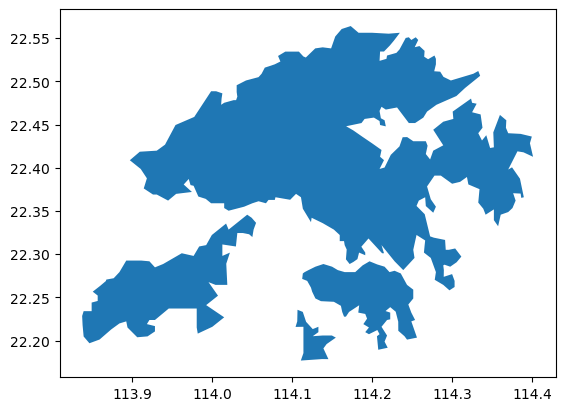

In [32]:
eez_and_land_boundaries_gdf[eez_and_land_boundaries_gdf.index=='Hong Kong'].plot()

In [33]:
def pipeline_within_country(pipeline_ls, 
                            pipeline_name, 
                            segment_name, 
                            project_id, 
                            results_by_country, 
                            status, 
                            fuel, 
                            length, 
                            remainders, 
                            international):
    '''
    Iterate through all countries, to see if the specified pipeline 
    is within each country (at least partially).
    
    If there is a portion within a given country, 
    saves the country name and length of pipeline to a df
    '''
    
    #print(pipeline_name, '--', segment_name)
    
    pipeline_remainders = pipeline_ls # initialize
    # will progressively remove pieces of the pipeline, 
    # as they intersect with each country's land mass
    
    geodetic_computation = pyproj.Geod(ellps="WGS84") # initialize
    
    length_total = geodetic_computation.geometry_length(pipeline_ls)/1000 # units km
    
    for country in eez_and_land_boundaries_gdf.index:
        
        country_geom = eez_and_land_boundaries_gdf.loc[country, 'geometry']
        
        if country_geom.intersects(pipeline_ls)==True:
            #print(country)
            pipeline_intersection = pipeline_ls.intersection(country_geom)
            pipeline_remainders = pipeline_remainders.difference(country_geom)
            
            length_per_country = geodetic_computation.geometry_length(pipeline_intersection)/1000 # units km
            length_per_country_fract = length_per_country / length_total
            
            one_result = (
                pipeline_name, 
                segment_name,
                project_id,
                country, 
                length_per_country, 
                length_per_country_fract,
                status,
                fuel,
                length)
            one_result_df = pandas.DataFrame(one_result).T
            one_result_df.columns = ['pipeline_name', 'segment_name', 'project_id', 'country', 
                                     'length_per_country', 'length_per_country_fract', 
                                     'status', 'fuel', 'length']
            
            # results_by_country = results_by_country.append(
            #     pandas.DataFrame(one_result_df), 
            #     sort=False)
            results_by_country = pandas.concat([results_by_country,
                one_result_df], axis=0, ignore_index=True, sort=False)
            
        else:
            pass

    results_by_country = results_by_country.reset_index(drop=True)
        
    if pipeline_remainders.is_empty==False:       
        remainders_length = geodetic_computation.geometry_length(pipeline_remainders)/1000 # units km
        
        if remainders_length > 0.01: # units: km
            #print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            #print("cue for "+pipeline_name+" -- "+segment_name)
            #print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            remainders_tuple = (pipeline_name, segment_name, project_id, remainders_length, pipeline_remainders)
            remainders = pandas.DataFrame(remainders_tuple).T
            #print(remainders)
            if pipeline_name == 'TransColorado Gas Pipeline':
                print(remainders_tuple)
                print(remainders)
            remainders.columns = ['pipeline_name', 'segment_name', 'project_id', 'length', 'geometry']
            print()
            print(f"for {pipeline_name}, pipeline_remainders.is_empty==False") # for db
            print(f"remainders_length: {remainders_length}") # for db
            print()
        
    else:
#         print(f"for {pipeline_name}, pipeline_remainders.is_empty is NOT False") # for db
        pass
    
    # alternative method: pipeline that's in international waters (not in world_eez_and_land_boundaries_gdf)
    #print(pipeline_name,segment_name)
    international_pipeline = pipeline_ls.difference(world_eez_and_land_boundaries_gdf)
    if international_pipeline.is_empty==False:
        international_length = geodetic_computation.geometry_length(international_pipeline)/1000 # units km
        international_tuple = (pipeline_name, international_length, international_pipeline)
        international = pandas.DataFrame(international_tuple).T
        international.columns = ['pipeline_name', 'length', 'geometry']
    else:
        pass
    
    return results_by_country, remainders, international

# Apply functions to data

In [34]:
# this step requires that there be no non-geometry data in the "Route" column, 
# meaning no letters or extraneous symbols (ex: ";;", "::", "--", etc.)
pipe_gpd = geopandas.GeoDataFrame(pipes_withroute_df)

# fix vic transmission system
#pipe_gpd.loc[pipe_gpd.ProjectID=='P1194','Route'] = '-35.66077, 147.01716:-35.67087, 147.01617:-35.69078, 147.01058:-35.69884, 146.99884:-35.70097, 146.98846:-35.72077, 146.95735:-35.73782, 146.95256:-35.7472, 146.93329:-35.75041, 146.92959:-35.75887, 146.92821:-35.77176, 146.91865:-35.77839, 146.90748:-35.77531, 146.87662:-35.79286, 146.84573:-35.82147, 146.81552:-35.82834, 146.79933:-35.83259, 146.76906:-35.85136, 146.76549:-35.85514, 146.7657:-35.85885, 146.76875:-35.86419, 146.76608:-35.87633, 146.75691:-35.87907, 146.75197:-35.88701, 146.74643:-35.90247, 146.73111:-35.91662, 146.71486:-35.92293, 146.70296:-35.93801, 146.69367:-35.95034, 146.69951:-35.96082, 146.69617:-35.99572, 146.69323:-35.99771, 146.69425:-36.00952, 146.69181:-36.01299, 146.68574:-36.02048, 146.68358:-36.040634, 146.685429 ; -36.836227, 144.235821:-36.842877, 144.223573:-36.879324, 144.207059:-36.918315, 144.194714:-36.94951, 144.187966:-37.001388, 144.179528:-37.022759, 144.170877:-37.044701, 144.167158:-37.061993, 144.169809:-37.075676, 144.1657:-37.076938, 144.167313:-37.134915, 144.15191:-37.134979, 144.148976:-37.136941, 144.148008:-37.140757, 144.149727:-37.161917, 144.14575:-37.182111, 144.15075:-37.184991, 144.148725:-37.190719, 144.149715:-37.200437, 144.148614:-37.207378, 144.144867:-37.2201, 144.144892:-37.220952, 144.142543:-37.229993, 144.140775:-37.245019, 144.140776:-37.254516, 144.158234:-37.258433, 144.160326:-37.260487, 144.164812:-37.263151, 144.164882 ; -37.263177, 144.164762:-37.26749, 144.170426:-37.270064, 144.178711:-37.263085, 144.195105:-37.269253, 144.238266:-37.268246, 144.239948:-37.26965, 144.247076:-37.268468, 144.255426:-37.26947, 144.280906:-37.26158, 144.302693:-37.262353, 144.308992:-37.257908, 144.313163:-37.259882, 144.329406:-37.256849, 144.335492:-37.257965, 144.343872:-37.251032, 144.364542:-37.248004, 144.368761:-37.247055, 144.375857:-37.246239, 144.388356:-37.248786, 144.412669:-37.253398, 144.421631 ; -37.884829, 145.070439:-37.899674, 145.06712:-37.899354, 145.064663:-37.910124, 145.061152 ; -37.951556, 145.047352:-37.951486, 145.047509 ; -37.951486, 145.047509:-37.951243, 145.047978 ; -37.910124, 145.061152:-37.938103, 145.055944:-37.94231, 145.052164:-37.951437, 145.051702:-37.951057, 145.048391:-37.951258, 145.047944 ; -37.909871, 145.061271:-37.910124, 145.061152 ; -37.884744, 145.070455:-37.884829, 145.070439 ; -36.041603, 145.950223:-36.055538, 145.995342:-36.055467, 146.014036:-36.063529, 146.049072:-36.067218, 146.085012:-36.067915, 146.134673:-36.074554, 146.190976:-36.077148, 146.20162:-36.080498, 146.259173:-36.087105, 146.332493:-36.086659, 146.423386 ; -36.035987, 145.932037:-36.041603, 145.950223 ; -36.03486, 145.928094:-36.035987, 145.932037 ; -35.849395, 145.562065:-35.882061, 145.560685:-35.898697, 145.597956:-35.926395, 145.598831:-35.940838, 145.610864:-35.94797, 145.622312:-35.951566, 145.622306:-35.951628, 145.632979:-35.955174, 145.641959:-35.955104, 145.686855:-35.959473, 145.692778:-35.980883, 145.7466:-36.001458, 145.822055:-36.003109, 145.82288:-36.018999, 145.871212:-36.03486, 145.928094 ; -36.343803, 145.032708:-36.351895, 145.041295:-36.356879, 145.054775:-36.362561, 145.060824:-36.368856, 145.075404:-36.372246, 145.078532:-36.372248, 145.080756:-36.381431, 145.096634:-36.386508, 145.116436:-36.403747, 145.159181:-36.406036, 145.172608:-36.416059, 145.204397:-36.415389, 145.209134:-36.416613, 145.20959:-36.421747, 145.233086:-36.4245, 145.2894:-36.433404, 145.304018:-36.431757, 145.327253:-36.43533, 145.333563:-36.435967, 145.348534:-36.440897, 145.365191:-36.441043, 145.375848:-36.448558, 145.381604:-36.45142, 145.388338:-36.451861, 145.408206 ; -38.262633, 146.425526:-38.263037, 146.425443 ; -38.254167, 146.427301:-38.262633, 146.425526 ; -38.25416, 146.427311:-38.254167, 146.427301 ; -38.249367, 146.435828:-38.25416, 146.427311 ; -38.15541, 146.511113:-38.165201, 146.509209:-38.18927, 146.48617:-38.200606, 146.47935:-38.203705, 146.463735:-38.236548, 146.45702:-38.245346, 146.442123:-38.249666, 146.441226:-38.249367, 146.435828 ; -38.15536, 146.511123:-38.15541, 146.511113 ; -37.347515, 145.056271:-37.347516, 145.056277 ; -37.332895, 144.983655:-37.335846, 145.014661:-37.334718, 145.022886:-37.336497, 145.031128:-37.347515, 145.056271 ; -37.2536, 144.421606:-37.261997, 144.421109:-37.272508, 144.437181:-37.276102, 144.450668:-37.277139, 144.483091:-37.273836, 144.484891:-37.277149, 144.488222:-37.276641, 144.495458:-37.274696, 144.498338:-37.281513, 144.551797:-37.281266, 144.571001:-37.290846, 144.615073:-37.299309, 144.684194:-37.306613, 144.721593:-37.306918, 144.767369:-37.303566, 144.793805:-37.306275, 144.801615:-37.310822, 144.831297:-37.309835, 144.832006:-37.3137, 144.846459:-37.314573, 144.873895:-37.31959, 144.913565:-37.323854, 144.923164:-37.332895, 144.983655 ; -37.790492, 144.697755:-37.791295, 144.697636 ; -37.790492, 144.697755:-37.755253, 144.703202:-37.753831, 144.706895:-37.718473, 144.712103 ; -36.490551, 146.111972:-36.487914, 146.115105:-36.479205, 146.136806:-36.473986, 146.160954:-36.466394, 146.178008:-36.460016, 146.197943:-36.457094, 146.232215:-36.45397, 146.232205:-36.453013, 146.23844:-36.449936, 146.240488:-36.450855, 146.242608:-36.437076, 146.263705:-36.406451, 146.297273:-36.405861, 146.310049:-36.400376, 146.311141:-36.398828, 146.316391:-36.396266, 146.31727:-36.392318, 146.322915:-36.39336, 146.331681:-36.39014, 146.336039:-36.372818, 146.35105:-36.370653, 146.3562:-36.361691, 146.359944:-36.35565, 146.364796:-36.347202, 146.364313:-36.342627, 146.368123:-36.335346, 146.387426:-36.332536, 146.392698:-36.327555, 146.396404:-36.307316, 146.407816:-36.297448, 146.408973:-36.276447, 146.421227:-36.259816, 146.427384:-36.250916, 146.432666:-36.245951, 146.439133:-36.243621, 146.439027:-36.228603, 146.455071:-36.213617, 146.464626:-36.208706, 146.474464:-36.205192, 146.476955:-36.200008, 146.493095:-36.199996, 146.504164:-36.192727, 146.511605:-36.190139, 146.518571:-36.179595, 146.525813:-36.170188, 146.538705:-36.16542, 146.541598:-36.160145, 146.551478:-36.158768, 146.55112:-36.154794, 146.556632:-36.14452, 146.580984:-36.137584, 146.586205:-36.13816, 146.621095:-36.125686, 146.639786:-36.113842, 146.644696:-36.111961, 146.64885:-36.107927, 146.652116:-36.096154, 146.658248:-36.091533, 146.669064:-36.086838, 146.694924:-36.078685, 146.72262:-36.076415, 146.747159:-36.075088, 146.748008:-36.076951, 146.76188:-36.07563, 146.771052:-36.079183, 146.778761:-36.080357, 146.791814 ; -36.490689, 146.111647:-36.490551, 146.111972 ; -36.726314, 145.545757:-36.721631, 145.555439:-36.708914, 145.569825:-36.69473, 145.595893:-36.69505, 145.597727:-36.674101, 145.632224:-36.672339, 145.640773:-36.644672, 145.671351:-36.633923, 145.703601:-36.627978, 145.706684:-36.620174, 145.71913:-36.619784, 145.724804:-36.616533, 145.72982:-36.610749, 145.747706:-36.600369, 145.771403:-36.599088, 145.77136:-36.596033, 145.785764:-36.583121, 145.814107:-36.572163, 145.847844:-36.56665, 145.854774:-36.555848, 145.874933:-36.547331, 145.899185:-36.537484, 145.920632:-36.536218, 145.920634:-36.527492, 145.937829:-36.524334, 145.951587:-36.524438, 145.964497:-36.519535, 145.97457:-36.516232, 145.992126:-36.515245, 146.015239:-36.516312, 146.026586:-36.514899, 146.03612:-36.516661, 146.037282:-36.508053, 146.069403:-36.490689, 146.111647 ; -37.347515, 145.056271:-37.342531, 145.056453:-37.335522, 145.063011:-37.327553, 145.064529:-37.322962, 145.063236:-37.322962, 145.061399:-37.315525, 145.062926:-37.295748, 145.061295:-37.294322, 145.062674:-37.286857, 145.063132:-37.285756, 145.06459:-37.276061, 145.062388:-37.274016, 145.058563:-37.25624, 145.063325:-37.244853, 145.059668:-37.241523, 145.061723:-37.237071, 145.060347:-37.23544, 145.060618:-37.230579, 145.069206:-37.221455, 145.071495:-37.220083, 145.074105:-37.203272, 145.075802:-37.193182, 145.080063:-37.182061, 145.080064:-37.177273, 145.08244:-37.169387, 145.079554:-37.159679, 145.079229:-37.155716, 145.081999:-37.143794, 145.084583:-37.121441, 145.093689:-37.118112, 145.093521:-37.113301, 145.100389:-37.104846, 145.10586:-37.098759, 145.113173:-37.08372, 145.112506:-37.072704, 145.121697:-37.071007, 145.130726:-37.067353, 145.133934:-37.067385, 145.139714:-37.061224, 145.149935:-37.060407, 145.155218:-37.062508, 145.169878:-37.04185, 145.191951:-37.03551, 145.191545:-37.03124, 145.18682:-37.01902, 145.184838:-37.01171, 145.178945:-36.990817, 145.178582:-36.97653, 145.1762:-36.973371, 145.172267:-36.957335, 145.170899:-36.956762, 145.168139:-36.933787, 145.166392:-36.926321, 145.175616:-36.919288, 145.179429:-36.905444, 145.193422:-36.903437, 145.198645:-36.887314, 145.20984:-36.861468, 145.248883:-36.855693, 145.25512:-36.847745, 145.276901:-36.834356, 145.296993:-36.827421, 145.316379:-36.825621, 145.317191:-36.812469, 145.345631:-36.800654, 145.363031:-36.783117, 145.404627:-36.778461, 145.410347:-36.771029, 145.43251:-36.772154, 145.451053:-36.759033, 145.464539:-36.754751, 145.474084:-36.751301, 145.47769:-36.74596, 145.496683:-36.72968, 145.529859:-36.726314, 145.545757 ; -37.574018, 144.995733:-37.554151, 144.99909:-37.553083, 145.00066:-37.531409, 145.002969:-37.504735, 144.99702:-37.442484, 145.007487:-37.441907, 145.009218:-37.414039, 145.016441:-37.410704, 145.018833:-37.40983, 145.022747:-37.40361, 145.025012:-37.403276, 145.027213:-37.397271, 145.032773:-37.365761, 145.038781:-37.361785, 145.043645:-37.35941, 145.05262:-37.353526, 145.057127:-37.347515, 145.056271 ; -37.577994, 144.995377:-37.59046, 144.993372:-37.597989, 145.000338:-37.619191, 144.995038:-37.627632, 144.994551:-37.633381, 144.991526:-37.65805, 144.987628:-37.660059, 144.988494:-37.670501, 144.985365:-37.679672, 144.985944:-37.679838, 144.984191:-37.685321, 144.98403:-37.688321, 144.981891:-37.68806, 144.97928:-37.692528, 144.978227 ; -37.575007, 144.995546:-37.577994, 144.995377 ; -38.509629, 142.856148:-38.527098, 142.889521:-38.536511, 142.91986:-38.548974, 142.948358:-38.555541, 142.956149 ; -38.508885, 142.852756:-38.509629, 142.856148 ; -38.400033, 142.634131:-38.416766, 142.666656:-38.441052, 142.705878:-38.448171, 142.72007:-38.462602, 142.755929:-38.479938, 142.784684:-38.490912, 142.808382:-38.508885, 142.852756 ; -38.084652, 145.49192:-38.094906, 145.489874 ; -38.088682, 145.491053:-38.084648, 145.491917 ; -37.577994, 144.995377:-37.579276, 145.033411:-37.574925, 145.068866:-37.579174, 145.100045:-37.576482, 145.116869:-37.575673, 145.136596:-37.582523, 145.194239:-37.588611, 145.219801:-37.584486, 145.239464:-37.587162, 145.246488:-37.589423, 145.276231:-37.591959, 145.279722:-37.593501, 145.289806:-37.602113, 145.312261:-37.608571, 145.321446:-37.618634, 145.327478:-37.631714, 145.340831:-37.633341, 145.341966:-37.641743, 145.336247:-37.65143, 145.332189:-37.662146, 145.333359:-37.664702, 145.334947:-37.667848, 145.340653:-37.669284, 145.352364:-37.673807, 145.355483:-37.683373, 145.384824:-37.685135, 145.416733:-37.701256, 145.447205:-37.712366, 145.474567:-37.715558, 145.47709:-37.715685, 145.484419:-37.718741, 145.493275:-37.723814, 145.499319:-37.733602, 145.504989:-37.745912, 145.507705:-37.747879, 145.509863:-37.771444, 145.510842:-37.780291, 145.514907:-37.788128, 145.515792:-37.79811, 145.519882:-37.819269, 145.518037:-37.848042, 145.523682:-37.857227, 145.527222:-37.877002, 145.530097:-37.881827, 145.533842:-37.888223, 145.532561:-37.892648, 145.53472:-37.903859, 145.533551:-37.917659, 145.529019:-37.919797, 145.531228:-37.929772, 145.531883:-37.956765, 145.529305:-37.965357, 145.532138:-37.996178, 145.526254:-37.997019, 145.528188:-38.006051, 145.528555:-38.010187, 145.526281:-38.013209, 145.527027:-38.015796, 145.531085:-38.021295, 145.532121:-38.034102, 145.526505:-38.04792, 145.526546:-38.062187, 145.523051:-38.063376, 145.526163 ; -37.577939, 144.994875:-37.577994, 144.995377 ; -38.279972, 141.583504:-38.282993, 141.576571:-38.287018, 141.573462:-38.301617, 141.571868:-38.303915, 141.573799:-38.321289, 141.570393:-38.321434, 141.580816:-38.330278, 141.587376:-38.362147, 141.586555:-38.379876, 141.605862:-38.381222, 141.632055 ; -37.98111, 145.209393:-37.982205, 145.210971 ; -37.806444, 145.224373:-37.80644, 145.224388 ; -37.78978, 145.308339:-37.789763, 145.308533 ; -37.789763, 145.308533:-37.789288, 145.309997:-37.785063, 145.311004:-37.786102, 145.319519:-37.78133, 145.325846:-37.776987, 145.326601:-37.773394, 145.331894:-37.760754, 145.334027 ; -37.784613, 145.275864:-37.78437, 145.276086 ; -37.808645, 145.21944:-37.808663, 145.219428 ; -37.808656, 145.219421:-37.807584, 145.220662:-37.804628, 145.230285:-37.790301, 145.247263:-37.780537, 145.24926:-37.783644, 145.274179:-37.78525, 145.276973:-37.782465, 145.284271:-37.786798, 145.292566:-37.789763, 145.308533 ; -37.760816, 145.333567:-37.760754, 145.334027 ; -37.760754, 145.334027:-37.760748, 145.334049 ; -38.218902, 147.156332:-38.219634, 147.16234 ; -38.15541, 146.511113:-38.167591, 146.563429:-38.179782, 146.717605:-38.218138, 147.107306:-38.218902, 147.156332 ; -38.149457, 146.47175:-38.151476, 146.477502:-38.15541, 146.511113 ; -38.140358, 146.435455:-38.140158, 146.443714:-38.144226, 146.449505:-38.145876, 146.461549:-38.149457, 146.47175 ; -38.273263, 146.423227:-38.263164, 146.425376 ; -38.193727, 145.907194:-38.194134, 145.915213:-38.203011, 145.928377:-38.209161, 145.933104:-38.212408, 145.941095:-38.214586, 145.952957:-38.213088, 145.963553:-38.217633, 145.987901:-38.216564, 145.994936:-38.218786, 146.013799:-38.216393, 146.039027:-38.212707, 146.051627:-38.214509, 146.066117:-38.213205, 146.085273:-38.215171, 146.120989:-38.214096, 146.128541:-38.216582, 146.146085:-38.21492, 146.155152:-38.216685, 146.169962:-38.20923, 146.183663:-38.209612, 146.189616:-38.205983, 146.195088:-38.206528, 146.206462:-38.201432, 146.212555:-38.199625, 146.219284:-38.201349, 146.224882:-38.20214, 146.243418:-38.200595, 146.263295:-38.208254, 146.275322:-38.209634, 146.280287:-38.212168, 146.281432:-38.215454, 146.293101:-38.219155, 146.295972:-38.226697, 146.292513:-38.232119, 146.286209:-38.236405, 146.289412:-38.23969, 146.288092:-38.245982, 146.291867:-38.247142, 146.294461:-38.25646, 146.297254:-38.258432, 146.305014:-38.268746, 146.313966:-38.276169, 146.315141:-38.283825, 146.320978:-38.291611, 146.329547:-38.295476, 146.336315:-38.295268, 146.34174:-38.299391, 146.351343:-38.302102, 146.371769:-38.305808, 146.376886:-38.308206, 146.389036:-38.302355, 146.400273:-38.286725, 146.403278:-38.27552, 146.422757:-38.273263, 146.423227 ; -38.273984, 146.425261:-38.274133, 146.424699 ; -38.274482, 146.426244:-38.273984, 146.425261 ; -38.273984, 146.425261:-38.273263, 146.423227 ; -38.016948, 145.21028:-38.019605, 145.224164:-38.027182, 145.235429:-38.043738, 145.245806:-38.052246, 145.25441:-38.05749, 145.262977:-38.064658, 145.266223:-38.065573, 145.273839:-38.075119, 145.284785 ; -38.07566, 145.284562:-38.075119, 145.284785 ; -38.075119, 145.284785:-38.082798, 145.34318 ; -38.015967, 145.210335:-38.016948, 145.21028 ; -38.108445, 145.541885:-38.113773, 145.571459:-38.123913, 145.588352:-38.126856, 145.599367:-38.133713, 145.65334:-38.136463, 145.654306:-38.148759, 145.739587:-38.149595, 145.78914:-38.155583, 145.807712:-38.155386, 145.827502:-38.158417, 145.839088:-38.167402, 145.84804:-38.172751, 145.856014:-38.175126, 145.876785:-38.180849, 145.890006:-38.184787, 145.897483:-38.193727, 145.907194 ; -38.082798, 145.34318:-38.090344, 145.421799:-38.087856, 145.439358:-38.087854, 145.457531:-38.089753, 145.471838:-38.094906, 145.489874 ; -38.094906, 145.489874:-38.108445, 145.541885 ; -36.086659, 146.423386:-36.097874, 146.439362:-36.109909, 146.464059:-36.121787, 146.481743:-36.124352, 146.489856:-36.130966, 146.49788:-36.146739, 146.531665:-36.155123, 146.555702 ; -37.995325, 141.9888:-38.022167, 142.007342:-38.03185, 142.020947:-38.059893, 142.019941:-38.068862, 142.021778:-38.104494, 142.021745:-38.12492, 142.023864:-38.154033, 142.018841:-38.178964, 142.006864:-38.205211, 142.002768:-38.239245, 141.993722 ; -37.76654, 141.991471:-37.772503, 141.989349:-37.801255, 141.990986:-37.836614, 141.985145:-37.83729, 141.987317:-37.843469, 141.987678:-37.886287, 141.970884:-37.905801, 141.967851:-37.919965, 141.975829:-37.947018, 141.978087:-37.965313, 141.982572:-37.980736, 141.983382:-37.99188, 141.986422:-37.995325, 141.9888 ; -38.329254, 143.053621:-38.386324, 142.995629:-38.396905, 142.968676:-38.408029, 142.959723:-38.413665, 142.951778:-38.432325, 142.918825:-38.454657, 142.887332:-38.469832, 142.857805:-38.47876, 142.847458:-38.489688, 142.841434:-38.502902, 142.837956 ; -37.987389, 145.208442:-37.98735, 145.211036:-37.984625, 145.211556 ; -37.987383, 145.208431:-37.987384, 145.208443 ; -37.740669, 145.136102:-37.742053, 145.136545:-37.741186, 145.13916:-37.743664, 145.151487:-37.747004, 145.150865:-37.749157, 145.169178:-37.763399, 145.166638:-37.766175, 145.184633:-37.795931, 145.179307:-37.800139, 145.182571:-37.805545, 145.19022:-37.804091, 145.204433:-37.805241, 145.214694:-37.806503, 145.214484:-37.808656, 145.219421 ; -37.910984, 145.236565:-37.977672, 145.222262:-37.976945, 145.2161:-37.980954, 145.215337:-37.981752, 145.211598 ; -37.808656, 145.219421:-37.826208, 145.220385:-37.826456, 145.22481:-37.832531, 145.224829:-37.832853, 145.227431:-37.847503, 145.227284:-37.852666, 145.243718:-37.871544, 145.233097:-37.898826, 145.233086:-37.905082, 145.237726:-37.910984, 145.236565 ; -37.700164, 145.05975:-37.700259, 145.059715 ; -37.710482, 145.083352:-37.736329, 145.117987:-37.740669, 145.136102 ; -37.72583, 145.104388:-37.726093, 145.1047 ; -37.710485, 145.083307:-37.710482, 145.083352 ; -37.710372, 145.08317:-37.710482, 145.083352 ; -37.700164, 145.05975:-37.701088, 145.069248:-37.704502, 145.068955:-37.706238, 145.077246:-37.710372, 145.08317 ; -37.710259, 145.083176:-37.710372, 145.08317 ; -37.692783, 144.990853:-37.69472, 145.011219:-37.69609, 145.022244:-37.694843, 145.023196:-37.700106, 145.043829:-37.698805, 145.04547:-37.700164, 145.05975 ; -37.700073, 145.059782:-37.700164, 145.05975 ; -37.694769, 145.010942:-37.695109, 145.010889 ; -37.692783, 144.990853:-37.693512, 144.99104 ; -37.692565, 144.9786:-37.692783, 144.990853 ; -37.692447, 144.990349:-37.692727, 144.990304 ; -37.791298, 144.697559:-37.791363, 144.697549 ; -37.587093, 144.723057:-37.594847, 144.719093:-37.619175, 144.718443:-37.622454, 144.719164:-37.625407, 144.723851:-37.63419, 144.731838:-37.63684, 144.731684:-37.642844, 144.735026:-37.646354, 144.727783:-37.733432, 144.709034:-37.734416, 144.71:-37.753789, 144.706832:-37.75521, 144.703137:-37.791298, 144.697559 ; -37.823029, 144.825777:-37.823641, 144.827478:-37.816396, 144.851173 ; -37.82293, 144.825147:-37.823029, 144.825777 ; -37.822972, 144.825079:-37.82293, 144.825147 ; -37.816721, 144.817016:-37.822458, 144.822397 ; -37.812269, 144.869277:-37.812613, 144.873406:-37.809777, 144.875361:-37.810687, 144.882985:-37.80576, 144.883933:-37.809536, 144.905281:-37.805738, 144.906863:-37.809181, 144.93576:-37.813696, 144.944382:-37.820676, 144.948051 ; -37.816743, 144.81697:-37.816742, 144.81698 ; -37.816738, 144.816977:-37.816742, 144.81698 ; -37.816742, 144.81698:-37.816723, 144.817011 ; -37.816723, 144.817011:-37.816721, 144.817016 ; -37.810296, 144.817808:-37.816721, 144.817016 ; -37.816721, 144.817016:-37.816718, 144.81702 ; -37.816396, 144.851173:-37.813138, 144.862802 ; -37.813138, 144.862802:-37.812269, 144.869277 ; -37.812084, 144.869382:-37.812269, 144.869277 ; -37.810514, 144.881526:-37.810568, 144.881676 ; -37.808491, 144.818099:-37.81025, 144.817816 ; -37.81025, 144.817816:-37.810296, 144.817808 ; -37.822458, 144.822397:-37.823833, 144.823688:-37.822972, 144.825079 ; -37.808329, 144.818133:-37.808492, 144.818104 ; -36.451855, 145.408541:-36.456427, 145.411732:-36.468487, 145.411151:-36.484539, 145.423625:-36.494364, 145.429162:-36.498688, 145.435074:-36.521011, 145.448413:-36.547576, 145.459463:-36.577744, 145.46761:-36.579059, 145.464883:-36.598892, 145.463002:-36.607458, 145.466767:-36.624267, 145.466857:-36.6318, 145.469452:-36.672563, 145.50248:-36.68286, 145.505831:-36.687596, 145.505836:-36.696264, 145.512536:-36.696299, 145.514186:-36.716515, 145.533619:-36.726314, 145.545757 ; -37.045122, 143.828842:-37.056525, 143.853869:-37.058586, 143.855241:-37.092252, 143.929551:-37.096419, 143.94271:-37.099403, 143.963662:-37.109575, 143.999564:-37.110744, 144.009923:-37.11652, 144.027891:-37.127819, 144.049963:-37.128721, 144.059243:-37.138052, 144.074733:-37.139084, 144.082225:-37.152593, 144.11424:-37.161786, 144.145652 ; -38.57138, 143.028163:-38.57252, 143.034921 ; -38.57252, 143.034921:-38.571066, 143.037117 ; -38.570648, 143.027073:-38.57138, 143.028163 ; -38.563913, 143.004481:-38.563318, 143.014311:-38.570648, 143.027073 ; -38.564236, 142.999121:-38.563913, 143.004481 ; -38.562274, 142.979749:-38.564236, 142.999121 ; -38.556952, 142.959621:-38.561231, 142.96946:-38.562274, 142.979749 ; -38.557737, 142.958267:-38.556952, 142.959621 ; -38.55583, 142.95642:-38.557737, 142.958267 ; -36.079962, 146.786407:-36.08196, 146.801179:-36.092114, 146.810997:-36.101956, 146.825973:-36.106064, 146.84538 ; -36.183203, 144.766905:-36.223631, 144.815741:-36.229572, 144.824436:-36.230194, 144.827836:-36.266728, 144.873741:-36.302775, 144.915061:-36.311664, 144.950007:-36.328648, 144.97749:-36.340673, 145.026615:-36.343803, 145.032284 ; -38.571059, 143.037122:-38.568797, 143.044401:-38.569439, 143.051041:-38.566223, 143.057101:-38.565044, 143.069583:-38.559188, 143.083812:-38.549125, 143.099513:-38.54763, 143.11913:-38.544868, 143.122944:-38.543647, 143.135458:-38.537339, 143.151865:-38.528438, 143.164571:-38.524524, 143.166599:-38.52469, 143.169109:-38.513442, 143.195326:-38.494862, 143.228606:-38.485463, 143.23076:-38.479082, 143.235556:-38.476631, 143.244777:-38.472528, 143.251132:-38.469604, 143.252557:-38.450467, 143.283629:-38.44519, 143.321227:-38.441109, 143.330325:-38.437721, 143.34617:-38.424956, 143.380195:-38.424884, 143.400592:-38.419371, 143.406068:-38.41596, 143.428704:-38.406593, 143.440583:-38.40413, 143.448807:-38.403771, 143.482737:-38.400346, 143.509316:-38.395236, 143.526688:-38.385255, 143.542034:-38.39389, 143.606025:-38.39107, 143.610678:-38.379081, 143.620547:-38.354319, 143.690565:-38.346492, 143.70357:-38.335212, 143.729738:-38.318833, 143.75434:-38.313634, 143.759811:-38.313948, 143.765262:-38.311752, 143.770401:-38.300946, 143.790232:-38.298649, 143.790664:-38.292179, 143.803796:-38.282996, 143.829381:-38.281196, 143.849225:-38.270187, 143.882221:-38.24462, 143.934285:-38.23593, 143.945405:-38.226751, 143.984441:-38.215491, 144.007305:-38.200982, 144.047725:-38.199977, 144.057849:-38.189035, 144.081579:-38.171507, 144.099299:-38.164275, 144.113237:-38.151376, 144.151903:-38.142988, 144.16634:-38.137262, 144.171975:-38.133042, 144.173613:-38.102635, 144.226007:-38.100176, 144.226818:-38.089714, 144.241983:-38.077853, 144.263317:-38.070167, 144.264918:-38.063478, 144.280078:-38.054843, 144.290679:-38.047027, 144.309755:-38.038638, 144.321463:-38.024932, 144.334071:-38.016386, 144.35506:-38.015936, 144.36108:-38.019225, 144.376698:-38.034661, 144.373938:-38.040012, 144.382115:-38.043592, 144.408389 ; -38.218805, 147.15632:-38.219533, 147.162303 ; -38.213955, 147.063229:-38.218044, 147.107313:-38.218805, 147.15632 ; -38.213947, 147.063136:-38.213955, 147.063229 ; -38.018175, 145.214314:-38.024765, 145.269277:-38.027614, 145.276357:-38.040793, 145.344859:-38.057258, 145.465156:-38.06887, 145.572253:-38.076729, 145.60124:-38.080959, 145.624501:-38.087429, 145.752726:-38.104832, 145.901025:-38.103121, 145.906594:-38.106887, 145.934192:-38.105652, 145.967648:-38.12359, 146.161579:-38.134263, 146.343159:-38.132496, 146.372347:-38.136019, 146.388959:-38.140957, 146.437751:-38.140054, 146.443746:-38.144137, 146.449559:-38.145785, 146.461584:-38.151384, 146.477534:-38.154201, 146.505763:-38.167498, 146.563453:-38.179688, 146.71762:-38.213947, 147.063136 ; -37.957393, 145.052393:-37.957394, 145.0524 ; -37.951459, 145.047283:-37.951486, 145.047509 ; -38.014129, 145.210571:-38.014171, 145.210563 ; -38.014113, 145.210507:-38.014129, 145.210571 ; -38.013544, 145.205878:-38.014113, 145.210507 ; -37.992817, 145.163257:-38.000347, 145.161661:-38.003048, 145.181649:-38.011958, 145.190118:-38.013544, 145.205878 ; -37.990665, 145.144019:-37.99307, 145.163117 ; -37.980605, 145.127755:-37.990665, 145.144019 ; -37.990665, 145.144019:-37.990556, 145.144205 ; -37.980605, 145.127755:-37.980615, 145.127768 ; -37.978542, 145.12545:-37.980605, 145.127755 ; -37.980596, 145.127743:-37.980605, 145.127755 ; -37.978542, 145.12545:-37.978583, 145.125493 ; -37.975768, 145.122508:-37.978542, 145.12545 ; -37.975768, 145.122508:-37.976049, 145.122429 ; -37.957374, 145.052071:-37.965735, 145.058055:-37.973369, 145.119964:-37.975768, 145.122508 ; -37.957374, 145.052071:-37.9574, 145.052392 ; -37.951486, 145.047509:-37.957374, 145.052071 ; -38.013561, 145.205875:-38.015814, 145.205436:-38.016948, 145.21028 ; -38.016948, 145.21028:-38.017144, 145.211571 ; -38.013544, 145.205878:-38.013561, 145.205875 ; -38.013471, 145.205892:-38.013544, 145.205878 ; -38.009004, 145.206719:-38.013471, 145.205892 ; -37.981183, 145.209159:-37.988962, 145.205726:-37.99023, 145.208033:-37.998552, 145.207227:-37.998821, 145.208736:-38.009004, 145.206719 ; -37.981115, 145.209385:-37.981183, 145.209159 ; -37.981183, 145.209159:-37.981143, 145.209237 ; -37.981115, 145.209385:-37.980922, 145.209587 ; -37.98111, 145.209393:-37.981115, 145.209385 ; -37.853886, 144.975372:-37.854013, 144.975457:-37.853891, 144.975746 ; -37.853882, 144.97572:-37.853904, 144.975717 ; -37.941921, 145.16615:-37.945082, 145.16966 ; -37.939896, 145.163879:-37.941921, 145.16615 ; -37.939896, 145.163879:-37.940415, 145.163592 ; -37.934591, 145.158006:-37.935214, 145.157718 ; -37.895876, 145.097384:-37.933936, 145.157298 ; -37.923201, 145.140865:-37.92322, 145.140844 ; -37.909616, 145.119244:-37.909683, 145.119403 ; -37.895306, 145.096394:-37.895876, 145.097384 ; -37.895341, 145.096333:-37.895295, 145.096375 ; -37.895295, 145.096375:-37.895306, 145.096394 ; -37.893804, 145.09376:-37.895295, 145.096375 ; -37.894102, 145.093147:-37.893804, 145.09376 ; -37.893801, 145.093752:-37.893804, 145.09376 ; -37.893804, 145.09376:-37.893801, 145.093752 ; -37.893499, 145.092709:-37.893801, 145.093752 ; -37.893053, 145.088927:-37.893499, 145.092709 ; -37.893008, 145.088545:-37.893053, 145.088927 ; -37.862778, 145.01934:-37.867362, 145.030872:-37.87501, 145.039971:-37.876109, 145.045447:-37.877275, 145.046891:-37.88191, 145.050565:-37.882763, 145.052068:-37.884744, 145.071929:-37.893008, 145.088545 ; -37.877873, 145.045582:-37.877933, 145.047398 ; -37.866767, 145.031327:-37.867577, 145.031135 ; -37.862778, 145.01934:-37.863583, 145.01919 ; -37.853761, 144.976038:-37.855413, 144.997904:-37.857248, 144.997579:-37.85856, 144.997326:-37.860945, 145.015159:-37.862778, 145.01934 ; -37.862734, 145.019239:-37.862778, 145.01934 ; -37.856229, 144.996575:-37.856384, 144.997732 ; -37.856228, 144.996571:-37.856229, 144.996575 ; -37.853891, 144.975746:-37.853761, 144.976038 ; -37.841183, 144.96174:-37.844752, 144.964252:-37.853761, 144.976038 ; -37.846688, 144.96717:-37.846595, 144.967302 ; -37.840763, 144.961311:-37.841183, 144.96174 ; -37.836081, 144.959112:-37.840763, 144.961311 ; -37.837883, 144.959429:-37.837752, 144.959876 ; -37.830136, 144.956383:-37.835842, 144.958998 ; -37.822447, 144.955526:-37.826642, 144.957508:-37.828321, 144.955533:-37.830136, 144.956383 ; -37.822447, 144.955526:-37.822445, 144.955535 ; -37.822266, 144.956048:-37.82229, 144.956106:-37.822291, 144.956059 ; -37.984714, 145.212374:-37.990014, 145.212925 ; -37.933936, 145.157298:-37.939896, 145.163879 ; -37.92322, 145.140844:-37.923332, 145.14094 ; -37.856229, 144.996575:-37.856242, 144.996569 ; -37.835842, 144.958998:-37.836029, 144.959056 ; -37.822289, 144.956069:-37.822447, 144.955526 ; -38.014042, 145.210504:-38.014201, 145.210811 ; -38.013471, 145.205892:-38.014042, 145.210504 ; -38.009004, 145.206719:-38.013471, 145.205892 ; -37.990014, 145.212925:-37.991381, 145.210232:-38.009004, 145.206719 ; -37.984625, 145.211556:-37.984714, 145.212374 ; -37.984476, 145.211456:-37.984625, 145.211556 ; -37.955868, 145.181722:-37.982829, 145.211769:-37.984476, 145.211456 ; -37.945082, 145.16966:-37.955868, 145.181722 ; -37.80028, 144.787769:-37.802271, 144.801773:-37.804902, 144.801472:-37.805369, 144.806502:-37.809342, 144.806714:-37.810295, 144.817802 ; -37.798017, 144.757756:-37.796712, 144.75793:-37.799155, 144.787913:-37.80028, 144.787769 ; -37.767737, 144.56366:-37.767347, 144.563664 ; -37.712788, 144.426281:-37.713998, 144.424277 ; -37.784089, 144.634324:-37.796169, 144.75149:-37.798017, 144.757756 ; -37.594066, 144.183257:-37.604262, 144.208088:-37.608152, 144.223095:-37.610041, 144.240585:-37.620801, 144.256339:-37.63426, 144.271458:-37.646079, 144.291401:-37.654208, 144.316283:-37.659416, 144.319992:-37.665296, 144.320876:-37.671422, 144.329662:-37.671291, 144.337837:-37.689069, 144.365871:-37.693625, 144.379066:-37.709232, 144.391855:-37.711766, 144.401174:-37.71403, 144.424501:-37.71966, 144.430436:-37.720771, 144.440264:-37.745581, 144.494948:-37.761398, 144.551157:-37.779024, 144.585396:-37.784089, 144.634324 ; -37.810296, 144.817808:-37.8163, 144.817138:-37.82228, 144.822758:-37.8191, 144.830136 ; -37.810295, 144.817802:-37.810296, 144.817808 ; -36.836058, 144.235922:-36.842813, 144.223471:-36.879832, 144.206776:-36.91872, 144.194461:-37.001367, 144.179414:-37.022735, 144.170763:-37.044702, 144.167038:-37.061992, 144.169689:-37.075704, 144.165566:-37.07697, 144.167183:-37.134821, 144.151803:-37.134885, 144.14889:-37.136938, 144.147879:-37.140766, 144.149601:-37.161954, 144.145622:-37.182092, 144.150626:-37.184965, 144.148604:-37.190719, 144.149594:-37.200399, 144.1485:-37.207361, 144.144747:-37.220037, 144.144772:-37.220885, 144.142433:-37.229985, 144.140655:-37.245063, 144.140655:-37.254574, 144.158134:-37.2585, 144.160232:-37.260544, 144.164694:-37.263177, 144.164762 ; -37.263177, 144.164762:-37.279105, 144.166246:-37.297809, 144.170684:-37.304588, 144.166856:-37.338134, 144.166612:-37.3415, 144.163014:-37.367895, 144.158168:-37.377591, 144.15243:-37.381894, 144.144204:-37.39498, 144.131736:-37.403691, 144.130307:-37.417177, 144.125421:-37.418586, 144.127613:-37.430691, 144.125758:-37.443351, 144.135811:-37.444949, 144.135189:-37.445873, 144.137851:-37.458416, 144.147962:-37.469983, 144.154269:-37.483162, 144.155599:-37.48395, 144.151762:-37.500911, 144.15427:-37.518685, 144.163161:-37.526561, 144.162827:-37.558676, 144.173679:-37.562764, 144.176932:-37.579011, 144.179925:-37.58436, 144.182588:-37.588218, 144.181916:-37.58849, 144.184262:-37.594066, 144.183257 ; -37.822458, 144.822397:-37.818948, 144.830963 ; -38.040544, 144.416113:-38.039797, 144.415712 ; -38.040544, 144.416113:-38.034506, 144.431589:-38.016088, 144.466584:-37.994046, 144.514178:-37.99269, 144.514425:-37.969075, 144.558839:-37.968777, 144.563145:-37.966731, 144.562795:-37.930885, 144.628359:-37.907178, 144.692994:-37.898078, 144.706267:-37.889864, 144.709249:-37.878763, 144.706212:-37.874161, 144.71043:-37.855745, 144.743923:-37.843869, 144.761087:-37.836228, 144.767677:-37.835215, 144.788596:-37.831133, 144.794328:-37.82246, 144.822392 ; -38.066426, 144.382754:-38.066898, 144.384038:-38.060061, 144.388133:-38.058196, 144.390388:-38.058459, 144.39266:-38.042155, 144.410329:-38.040544, 144.416113 ; -37.82246, 144.822392:-37.822458, 144.822397 ; -37.798017, 144.757756:-37.80028, 144.787769 ; -37.80028, 144.787769:-37.802234, 144.801826:-37.804866, 144.801534:-37.805355, 144.806836:-37.809259, 144.806758:-37.81025, 144.81781 ; -37.81025, 144.817816:-37.816273, 144.817882:-37.816486, 144.82047:-37.820897, 144.825025:-37.819222, 144.829484 ; -37.81025, 144.81781:-37.81025, 144.817816 ; -37.791298, 144.697559:-37.796082, 144.751442:-37.798017, 144.757756 ; -37.784089, 144.634324:-37.791298, 144.697559 ; -38.043277, 144.408869:-38.035243, 144.421403:-38.022861, 144.448216:-38.02337, 144.453895:-38.016027, 144.466545:-37.994, 144.514116:-37.992657, 144.514356:-37.970916, 144.555627:-37.969919, 144.554782:-37.869236, 144.573385:-37.865213, 144.570877:-37.859534, 144.57151:-37.855203, 144.578508:-37.855092, 144.581226:-37.837245, 144.603284:-37.832185, 144.605213:-37.824873, 144.618266:-37.818881, 144.619603:-37.803717, 144.631056:-37.784089, 144.634324 ; -38.063736, 145.526599:-38.068957, 145.572185:-38.076821, 145.601208:-38.081038, 145.624256:-38.086503, 145.736035 ; -38.367815, 142.605771:-38.38711, 142.631938:-38.39975, 142.634219 ; -38.367396, 142.602875:-38.367815, 142.605771 ; -38.28161, 142.495933:-38.282744, 142.499665:-38.292055, 142.511693:-38.298303, 142.525395:-38.335201, 142.565483:-38.339841, 142.572304:-38.349854, 142.579313:-38.367396, 142.602875 ; -38.28006, 141.584024:-38.272111, 141.615374:-38.268957, 141.637904:-38.26709, 141.640086:-38.255882, 141.67784:-38.247832, 141.69876:-38.247495, 141.710432:-38.229635, 141.749058:-38.223947, 141.769157:-38.227099, 141.813619:-38.226435, 141.832487:-38.232139, 141.86975:-38.23593, 141.915708:-38.24069, 142.012846:-38.24174, 142.105539:-38.245063, 142.156325:-38.251146, 142.191079:-38.250811, 142.22556:-38.25516, 142.314763:-38.267344, 142.441995:-38.278667, 142.475818:-38.28161, 142.495933 ; -37.587063, 144.108345:-37.590057, 144.114646:-37.596297, 144.156355:-37.594066, 144.183257 ; -37.586166, 144.10128:-37.587063, 144.108345 ; -37.567953, 143.932874:-37.569848, 143.992585:-37.572349, 143.999005:-37.576722, 144.061427:-37.580061, 144.069187:-37.582026, 144.08531:-37.583714, 144.087835:-37.586166, 144.10128 ; -36.040634, 146.685429:-36.088736, 146.678336'

pipe_gpd['geometry'] = numpy.nan

for row in pipe_gpd.index:
    #if pipe_gpd.iloc[row-1]['ProjectID'] in ['P4667']:
    #    pass
    linestring = convert_gfit_to_linestring(
        str(pipe_gpd.at[row, 'Route']), 
        pipe_gpd.at[row, 'PipelineName'], 
        pipe_gpd.at[row, 'SegmentName'], 
        pipe_gpd.at[row, 'ProjectID'], 
        pipe_gpd.at[row, 'Status'], 
        pipe_gpd.at[row, 'Fuel'], 
        pipe_gpd.at[row, 'LengthMergedKm'])
    pipe_gpd.at[row, 'geometry'] = linestring

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_84910/2343816540.py:8: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  pipe_gpd['geometry'] = numpy.nan


Lawe-Lawe Oil Pipeline 
Curaray-Andoas Oil Pipeline 
Tempino to Plaju Crude Oil Pipeline (TPCOP) 
Rabi-Cap Lopez Oil Pipeline 
Rabi-Gamba Oil Pipeline 
Onal-Coucal Oil Pipeline 
Camisea NGL Pipeline 
Víbora-Sirari-Yapacaní-Humberto Suárez Oil Pipeline ONSZ-1C
Surubí-Carrasco Oil Pipeline 
Carrasco-Cochabamba Oil Pipeline 
Carrasco-Caranda Oil Pipeline 
Víbora-Sirari-Yapacaní-Humberto Suárez Oil Pipeline ONSZ-1A
Cochabamba-Arica Oil Pipeline 
Santa Cruz-Cochabamba Oil Pipeline 
Caranda-Santa Cruz Oil Pipeline 
Lamu Port-South Sudan (LAPSSET) Pipeline South Sudan–Lokichar Oil Pipeline Segment
Cerrillos-Chorety Oil Pipeline 
Camiri-Santa Cruz Oil Pipeline 
Barrow Island Oil Pipeline 
Tigüipa-Salinas Oil Pipeline 
Camiri-Villamontes Oil Pipeline 
Dongjiakou Port–Weifang-Luzhong Oil Pipeline Phase I Dongjiakou–Binhai District
Camiri-Yacuiba Oil Pipeline 
OSCAB Oil Pipeline 
ORBEL Pipeline 
OSDUC Pipeline 
ORBIG Pipeline 
OSVAT-34 Oil Pipeline 
OSVAT-30 Oil Pipeline 
OSVAT Oil Pipeline 
OSBA

In [81]:
# now import all the geojson files that exist and replace the geometry column

In [82]:
geojson_route_files = list(
    pathlib.Path(
        '/Users/baird/Google Drive/Shared drives/GEM Shared Drive/Programs/Oil & Gas Program/Global Oil and Gas Infrastructure Trackers (GOIT, GGIT)/Data - geojson files/'
    ).rglob('*.geojson')
)

In [83]:
# note as of Feb 2024 geopandas doesn't allow you to read in point values, 
# every geometry type must be linestring or multilinestring. Some of the routes Clay is
# making have valves in the pipelines on OSM, which are points, so there needs to be a
# workaround that lets geopandas open the files and read them properly
# https://github.com/geopandas/geopandas/issues/2962
for file in geojson_route_files:
    project_id = str(file).split('/')[-1][:-8]
    #print(project_id)
    if project_id in ['P0024','P0057']:
        continue
        #file_df = geopandas.read_file(file, ignore_geometry=True)
        #pipeline_location = file_df.loc[file_df.man_made=='pipeline'].index[0]
        #file_gdf = geopandas.read_file(file, rows=slice(pipeline_location,pipeline_location+1))       
    else:
        file_gdf = geopandas.read_file(file)
    file_geometry_dissolved = file_gdf.dissolve().geometry

    pipe_gpd.loc[pipe_gpd.ProjectID==project_id,'geometry'] = file_geometry_dissolved[0]
#geopandas.read_file(geojson_route_files[0]).dissolve().geometry

<Axes: >

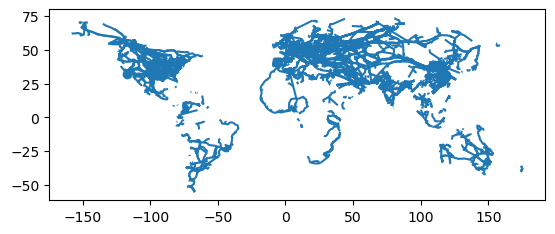

In [84]:
pipe_gpd.geometry.plot()

In [85]:
# calculate length by country
# get coord_str for each pipeline that has route coordinates
# choose pipes_withroute_df to process
#pipeline_df = pipe.copy()

results_by_country = pandas.DataFrame(
    columns=['pipeline_name', 'segment_name', 'project_id', 'country', 'length_per_country', 'status', 'fuel', 'length']
)

remainders = geopandas.GeoDataFrame()
international = geopandas.GeoDataFrame()

for sel_index in pipe_gpd.index:
    pipeline_name = pipe_gpd.at[sel_index, 'PipelineName']
    segment_name = pipe_gpd.at[sel_index, 'SegmentName']
    project_id = pipe_gpd.at[sel_index, 'ProjectID']
    
    print(pipeline_name, segment_name, project_id)
    
    status = pipe_gpd.at[sel_index, 'Status']
    fuel = pipe_gpd.at[sel_index, 'Fuel']
    length = pipe_gpd.at[sel_index, 'LengthKnownKm']
    coord_str = str(pipe_gpd.at[sel_index, 'Route'])
    
    # pipeline_ls = convert_gfit_to_linestring(coord_str, 
    #                                          pipeline_name, 
    #                                          segment_name, 
    #                                          project_id, 
    #                                          status, 
    #                                          fuel, 
    #                                          length)

    pipeline_ls = pipe_gpd.at[sel_index, 'geometry']
    
    results_by_country, remainders, international = pipeline_within_country(
        pipeline_ls, 
        pipeline_name, 
        segment_name, 
        project_id, 
        results_by_country, 
        status, 
        fuel, 
        length, 
        remainders, 
        international)

Lawe-Lawe Oil Pipeline  P0973
Curaray-Andoas Oil Pipeline  P1228
Tempino to Plaju Crude Oil Pipeline (TPCOP)  P0987
Rabi-Cap Lopez Oil Pipeline  P3685
Rabi-Gamba Oil Pipeline  P3686
Onal-Coucal Oil Pipeline  P3687
Camisea NGL Pipeline  P3551
Víbora-Sirari-Yapacaní-Humberto Suárez Oil Pipeline ONSZ-1C P5425
Surubí-Carrasco Oil Pipeline  P5427
Carrasco-Cochabamba Oil Pipeline  P3115
Carrasco-Caranda Oil Pipeline  P3117
Víbora-Sirari-Yapacaní-Humberto Suárez Oil Pipeline ONSZ-1A P3116
Cochabamba-Arica Oil Pipeline  P3113
Santa Cruz-Cochabamba Oil Pipeline  P3114
Caranda-Santa Cruz Oil Pipeline  P5426
Lamu Port-South Sudan (LAPSSET) Pipeline South Sudan–Lokichar Oil Pipeline Segment P0538
Cerrillos-Chorety Oil Pipeline  P5428
Camiri-Santa Cruz Oil Pipeline  P3118
Barrow Island Oil Pipeline  P1218
Tigüipa-Salinas Oil Pipeline  P5429
Camiri-Villamontes Oil Pipeline  P3120
Dongjiakou Port–Weifang-Luzhong Oil Pipeline Phase I Dongjiakou–Binhai District P1406
Camiri-Yacuiba Oil Pipeline  P3119


# Now go through all pipelines that DON'T have a route and fill in missing length info

this script assumes that a pipeline is equally spread across multiple countries if there's no route information

In [86]:
results_by_country_noroute = pandas.DataFrame(
    columns=['pipeline_name', 'segment_name', 'project_id', 'country', 'length_per_country', 'status', 'fuel', 'length']
)

for sel_index in pipes_noroute_df.index:

    pipeline_name = pipes_noroute_df.at[sel_index, 'PipelineName']
    segment_name = pipes_noroute_df.at[sel_index, 'SegmentName']
    project_id = pipes_noroute_df.at[sel_index, 'ProjectID']
    status = pipes_noroute_df.at[sel_index, 'Status']
    fuel = pipes_noroute_df.at[sel_index, 'Fuel']
    length = pipes_noroute_df.at[sel_index, 'LengthKnownKm']
    coord_str = str(pipes_noroute_df.at[sel_index, 'Route'])
    
    #print(pipeline_name, segment_name, coord_str, length)
    
    ncountries = pipes_noroute_df.at[sel_index, 'NumberOfCountries']

    # if it crosses into more than one country
    if ncountries>1:

        country_list = pipes_noroute_df.at[sel_index, 'Countries'].split(',')
        country_list = [i.strip() for i in country_list]

        for country in country_list:
            length_per_country = length/country_list.__len__()
            length_per_country_fract = 1/country_list.__len__()

            one_result = (
                pipeline_name, 
                segment_name,
                project_id,
                country, 
                length_per_country, 
                length_per_country_fract,
                status,
                fuel,
                length)
            one_result_df = pandas.DataFrame(one_result).T
            one_result_df.columns = ['pipeline_name', 'segment_name', 'project_id', 'country', 
                                     'length_per_country', 'length_per_country_fract', 
                                     'status', 'fuel', 'length']

            results_by_country_noroute = pandas.concat([results_by_country_noroute,
            pandas.DataFrame(one_result_df)], axis=0,
            sort=False)

    else:
        country = pipes_noroute_df.at[sel_index, 'Countries']

        length_per_country = length
        length_per_country_fract = 1.0

        one_result = (
            pipeline_name, 
            segment_name,
            project_id,
            country, 
            length_per_country, 
            length_per_country_fract,
            status,
            fuel,
            length)
        one_result_df = pandas.DataFrame(one_result).T
        one_result_df.columns = ['pipeline_name', 'segment_name', 'project_id', 'country', 
                                 'length_per_country', 'length_per_country_fract', 
                                 'status', 'fuel', 'length']

        results_by_country_noroute = pandas.concat([results_by_country_noroute,
            pandas.DataFrame(one_result_df)], axis=0,
            sort=False)

In [87]:
results_by_country_combined = pandas.concat([results_by_country,
                                             results_by_country_noroute],
                                            axis=0, sort=False)

# Check Mean Wiggle Factor, & Outliers

# Clean and export results

In [88]:
# export length estimates by country and pipeline
results_by_country_combined = results_by_country_combined[['pipeline_name','segment_name',
                                                          'project_id', 'country', 'length_per_country', 
                                                           'length', 'length_per_country_fract']]
results_by_country_combined.rename(columns={
                                    'pipeline_name':'PipelineName',
                                    'segment_name':'SegmentName',
                                    'project_id':'ProjectID',
                                    'country':'Country',
                                    'length_per_country':'LengthEstimateKmByCountry',
                                    'length':'LengthEstimateKm',
                                    'length_per_country_fract':'LengthPerCountryFraction'}, inplace=True)

# change Alaska to United States
# change Canary Islands to Spain
results_by_country_combined['Country'].replace('Alaska', 'United States', inplace=True)
results_by_country_combined['Country'].replace('Canary Islands', 'Morocco', inplace=True) # FOR Nigeria-Morocco Pipeline ONLY!!
results_by_country_combined['Country'].replace('Senkaku Islands', 'Japan', inplace=True)

results_by_country_combined.sort_values('ProjectID', inplace=True)

results_by_country_combined.to_excel('Estimated_Length-Results_By_Country_'+type+'.xlsx')

In [89]:
results_by_country_combined

,PipelineName,SegmentName,ProjectID,Country,LengthEstimateKmByCountry,LengthEstimateKm,LengthPerCountryFraction
0,Fuqing LNG Terminal Transport Pipeline,Fuqing LNG terminal transport pipeline,,China,104.0,104.0,1.0
982,Alberta Clipper Oil Pipeline,,P0001,United States,463.732751,1790.0,0.296661
981,Alberta Clipper Oil Pipeline,,P0001,Canada,1099.440303,1790.0,0.703339
1039,Athabasca Oil Pipeline,,P0002,Canada,418.095904,542.35,1.0
881,Bakken Expansion Pipeline,,P0004,United States,92.467553,260.71,0.35266
...,...,...,...,...,...,...,...
0,Huangze Operating Area Internal Oil Pipeline,,P6285,China,NaN,NaN,1.0
1382,Mamu-Yushan Oil Pipeline,Pipeline 1,P6286,China,132.220993,28.5,1.0
1383,Mamu-Yushan Oil Pipeline,Pipeline 2,P6287,China,132.220993,28.5,1.0
1384,Waidiao-Mamu Oil Pipeline,,P6288,China,10.71429,12.0,1.0


## create the estimated length by each pipeline (has "--" where no route exists)

In [90]:
results_by_pipeline_withroute = results_by_country.copy()[['project_id','length_per_country']]
results_by_pipeline_withroute = pandas.DataFrame(results_by_country.groupby("project_id")["length_per_country"].sum())

# then add in the missing route project_ids and set the length to '--'
noroute_projectids = list(set(results_by_country_noroute['project_id']))

results_by_pipeline_noroute = pandas.DataFrame({'length_per_country':['--']*noroute_projectids.__len__()},
                                              index=noroute_projectids)
results_by_pipeline_noroute.index.name = 'project_id'

results_by_pipeline_combined = pandas.concat([results_by_pipeline_withroute,results_by_pipeline_noroute])
results_by_pipeline_combined.sort_index(inplace=True)
results_by_pipeline_combined.index.name = 'ProjectID'
results_by_pipeline_combined.rename({'length_per_country':'LengthEstimateKmByCountry'})

#results_by_pipeline_combined = results_by_country_noroute.copy()[['project_id','length_per_country']]
results_by_pipeline_combined.to_excel('Estimated_Length-Results_By_Pipeline_'+type+'.xlsx')